# IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder as oe
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import Pool, cv
from sklearn.metrics import roc_curve, roc_auc_score
import optuna

C:\Users\GAR1\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# LOADING OF DATA

In [2]:
train = pd.read_csv('training_set_features.csv', index_col='respondent_id')

In [3]:
test = pd.read_csv('test_set_features.csv', index_col='respondent_id')

In [4]:
labels = pd.read_csv('./training_set_labels.csv', index_col='respondent_id')

In [5]:
num_cols = train.select_dtypes('number').columns

In [6]:
cat_cols = ['race','sex','marital_status','rent_or_own','hhs_geo_region','census_msa','employment_industry','employment_occupation']

In [7]:
ord_cols = ['age_group','education','income_poverty','employment_status']

# Impute train

In [8]:
# Categorical columns None
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='None')

In [9]:
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

# Impute test

In [10]:
# Categorical columns None
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='None')

In [11]:
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

# train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split( train, labels, test_size=0.25, random_state=42)

In [13]:
# Get the index number of categorical features
categorical_features_indices = np.where(X_train.dtypes != float)[0]

In [15]:
train_dataset = Pool(data=X_train,
                     label=y_train.xyz_vaccine,
                     cat_features = categorical_features_indices)

# optimized values of parameters

In [16]:
final_model = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices,iterations=500,
    learning_rate=0.05745075659543725,
    random_strength=4,
    bagging_temperature=8,
    max_bin=5,
    grow_policy='Lossguide',
    min_data_in_leaf=7,
    max_depth=6,
    l2_leaf_reg=11.323094517862078,
    one_hot_max_size=10,
    auto_class_weights='Balanced')

In [17]:
final_model.fit(X_train, y_train.xyz_vaccine)

In [18]:
predictions_h1 = final_model.predict_proba(X_test)

In [19]:
predictions_h1 = predictions_h1[:,1].reshape(-1,1)

In [20]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

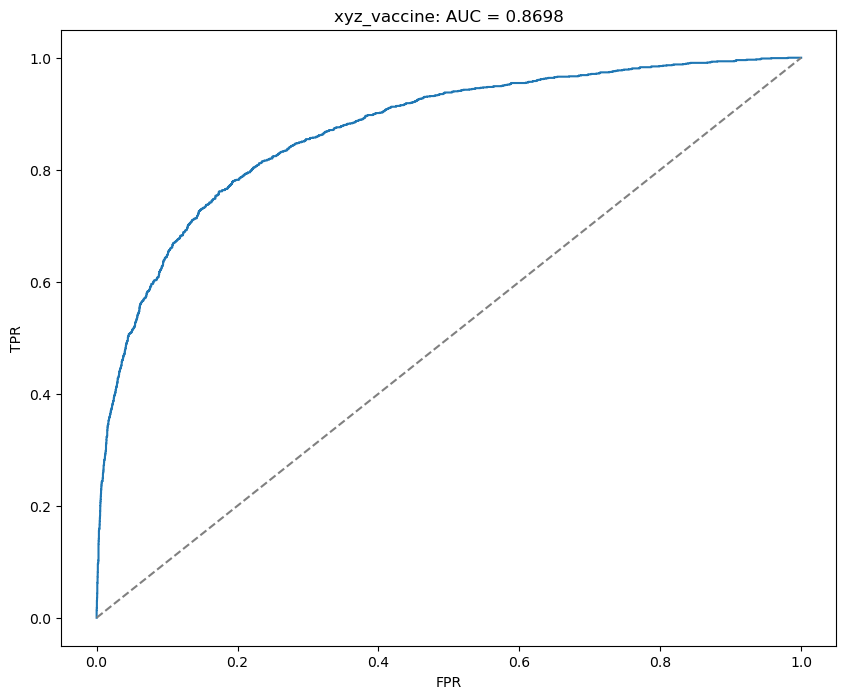

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['xyz_vaccine'], 
    predictions_h1, 
    'xyz_vaccine',
    ax=ax
)

# roc_auc_score

In [23]:
roc_auc_score(y_test.xyz_vaccine, predictions_h1)

0.8698071489329731

In [24]:
train_dataset_se = Pool(data=X_train,
                     label=y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [25]:
final_model_se = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices,iterations=1500,
    learning_rate=0.015393853845985255,
    random_strength=3,
    bagging_temperature=7,
    max_bin=8,
    grow_policy='Lossguide',
    min_data_in_leaf=1,
    max_depth=5,
    l2_leaf_reg=0.03977425239611938,
    one_hot_max_size=500,
    auto_class_weights='Balanced')

In [26]:
final_model_se.fit(X_train, y_train.seasonal_vaccine)

In [27]:
predictions_se = final_model_se.predict_proba(X_test)

In [28]:
predictions_se = predictions_se[:,1].reshape(-1,1)

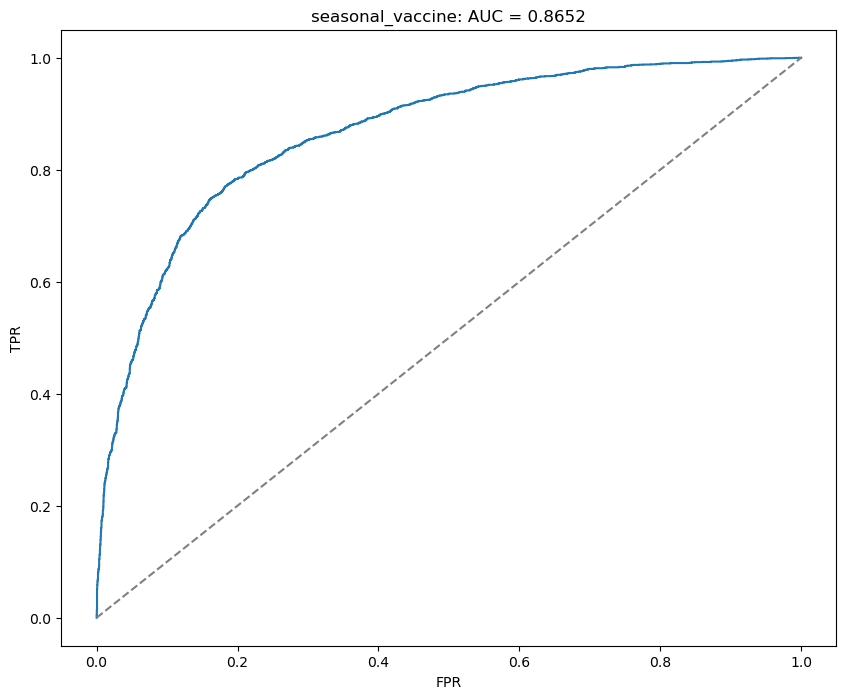

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['seasonal_vaccine'], 
    predictions_se, 
    'seasonal_vaccine',
    ax=ax
)

# roc_auc_score

In [30]:
roc_auc_score(y_test.seasonal_vaccine, predictions_se)

0.8652287312418534

# combined roc_auc_score

In [31]:
# Let's see the score combined of the two best predictions
roc_auc_score(y_test, np.hstack((predictions_h1, predictions_se)))

0.8675179400874132

# retrain on full dataset

# seasonal

In [32]:
final_model_se.fit(train, labels.seasonal_vaccine)
final_se = final_model_se.predict_proba(test)
final_se = final_se[:,1].reshape(-1,1)

# xyz

In [33]:
final_model.fit(train, labels.xyz_vaccine)
final_h1 = final_model.predict_proba(test)
final_h1 = final_h1[:,1].reshape(-1,1)

# submission

In [34]:
submission_df = pd.read_csv("submission_format.csv", 
                            index_col="respondent_id")

In [35]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["xyz_vaccine"] = final_h1
submission_df["seasonal_vaccine"] = final_se

submission_df.head()

,xyz_vaccine,seasonal_vaccine
respondent_id,,
26707,0.385558,0.271276
26708,0.102702,0.039441
26709,0.475290,0.733715
26710,0.876236,0.899717
26711,0.654207,0.506036


In [36]:
submission_df.to_csv('submission_Classification.csv', index=True)